In [1]:
import numpy as np
import glob
import cv2
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, BatchNormalization, Activation, Dropout
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc
K.set_image_data_format('channels_last')

%matplotlib inline

In [3]:
data_path = 'train_data/'
categories = [line.strip() for line in open('categories.txt')]
img_size = (100,100)
batch_size = 2000

### Data preprocessing

In [4]:
#Load and augment images from file.
pro_var = dict(directory = data_path, target_size = img_size, color_mode = 'grayscale', 
               classes = categories, batch_size = batch_size)

test_batch = ImageDataGenerator().flow_from_directory(**pro_var)
rotated_batch = ImageDataGenerator(rotation_range = 90).flow_from_directory(**pro_var)
zoom_batch = ImageDataGenerator(zoom_range = [1.5,2]).flow_from_directory(**pro_var)
shear_batch = ImageDataGenerator(shear_range = 45).flow_from_directory(**pro_var)

Found 1680 images belonging to 4 classes.
Found 1680 images belonging to 4 classes.
Found 1680 images belonging to 4 classes.
Found 1680 images belonging to 4 classes.


In [5]:
#Generate image batches.
images, labels = next(test_batch)
rot_img, rot_lab = next(rotated_batch)
zoom_img, zoom_lab = next(zoom_batch)
shear_img, shear_lab = next(shear_batch)

In [6]:
#Visualise images.

def image_visual(images, size = (12,12), rows = 1, labels = None):
    '''
    Displays images with corresponding encoded labels above.
    
    param images: (n,N,N,3) array containing image data
    param size: (w,h) size of grid of displayed images
    param rows: number of rows of images
    param labels: image labels
    '''
    if type(images[0]) is np.ndarray:
        images = np.array(images).astype(np.uint8)
        if (images.shape[-1] != 3):
            images = images.transpose((0,2,3,1))
        
        fig = plt.figure(figsize = size)
        cols = len(images)//rows if len(images) % 2 -- 0 else len(images)//rows + 1
        for i in range(len(images)):
            sub_plt = fig.add_subplot(rows, cols, i + 1)
            sub_plt.axis('off')
            
            if labels is not None:
                sub_plt.set_title(labels[i])
            plt.imshow(images[i])

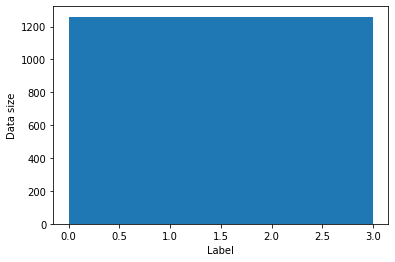

{0: 1260, 1: 1260, 2: 1260, 3: 1260}

In [7]:
#Visualise data distribution.
target = np.concatenate((rot_lab, zoom_lab, shear_lab))
train_set = np.concatenate((rot_img, zoom_img, shear_img))

data_lab = np.argmax(target, axis = 1)
unique, counts = np.unique(data_lab, return_counts = True)
plt.hist(data_lab, bins = len(categories))
plt.xlabel('Label')
plt.ylabel('Data size')
plt.show();

dict(zip(unique, counts))

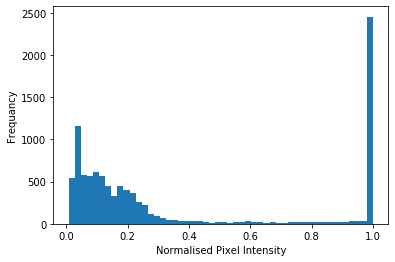

In [39]:
#Plot pixel intensity distribution.
intensity = train_set[0].flatten()
plt.hist(intensity, bins = 50)
plt.xlabel('Normalised Pixel Intensity')
plt.ylabel('Frequancy')
plt.savefig('intensity.pdf')
plt.show()

In [9]:
#Shuffle dataset.
perm_im = np.random.permutation(train_set.shape[0])
train_set = train_set[perm_im]
target = target[perm_im]

In [10]:
#Standardise inputs.
train_set = train_set/train_set.max()

#Split into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(train_set, target, test_size = 0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3528, 100, 100, 1), (1512, 100, 100, 1), (3528, 4), (1512, 4))

### Network design and training

In [11]:
def CNN(image, classes):
    '''
    Convolutiona Neural Network architecture for image classification.
    param image: (N,N,3) image 
    param classes: list containing image classes
    
    return: Keras Model
    '''
    #Common layer params
    conv_var = dict(kernel_size = (3,3), activation = 'relu', padding = 'same')
    pool_var = dict(pool_size = (2,2))
    
    #Network architecture.
    i = Input(shape=image.shape)
    
    x = Conv2D(32, **conv_var)(i)
    x = Conv2D(32, **conv_var)(x)
    x = MaxPooling2D(**pool_var)(x)
    
    x = Conv2D(64, **conv_var)(x)
    x = Conv2D(64, **conv_var)(x)
    x = MaxPooling2D(**pool_var)(x)
    x = Flatten()(x)
    
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    o = Dense(len(classes), activation = 'softmax')(x)
    
    return Model(i, o, name='CNN')
    

In [13]:
#Create CNN model.
cnn = CNN(x_train[0], categories)

In [278]:
#Show model summary.
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 25, 25, 64)        0       

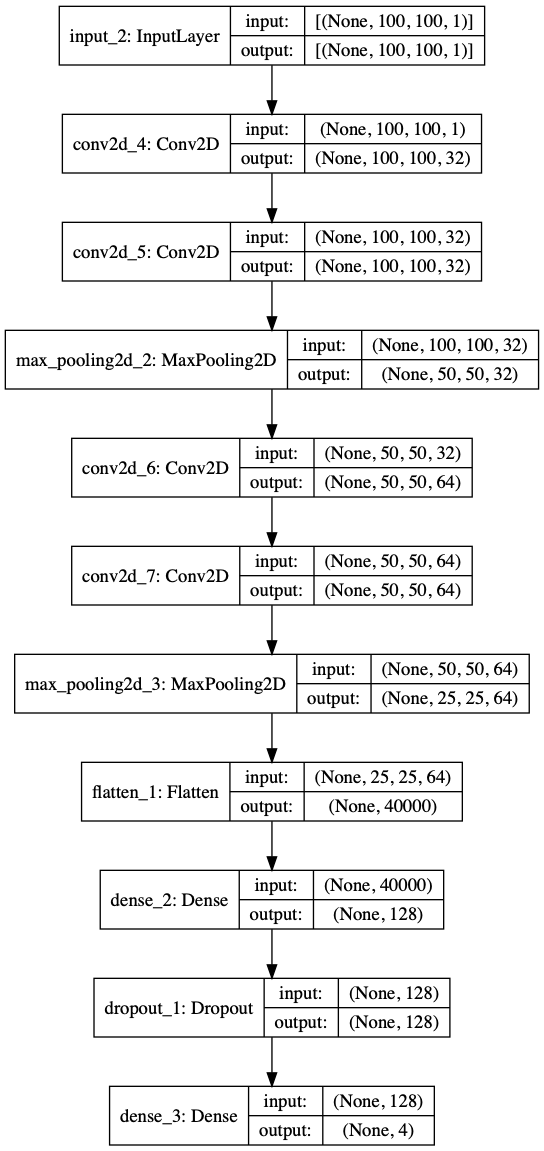

In [16]:
plot_model(cnn, show_shapes = True)

In [17]:
#Compile model.
cnn.compile(optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [18]:
#Train model using training data.
cnn.fit(x_train, y_train, epochs = 10, verbose = 1, batch_size = 128, validation_data = [x_test, y_test], shuffle = True);

Train on 3528 samples, validate on 1512 samples
Epoch 1/10
3528/3528 [==============================] - 142s 40ms/sample - loss: 0.8398 - acc: 0.6375 - val_loss: 0.3122 - val_acc: 0.9120
Epoch 2/10
3528/3528 [==============================] - 123s 35ms/sample - loss: 0.2372 - acc: 0.9212 - val_loss: 0.1141 - val_acc: 0.9563
Epoch 3/10
3528/3528 [==============================] - 121s 34ms/sample - loss: 0.1022 - acc: 0.9654 - val_loss: 0.0677 - val_acc: 0.9749
Epoch 4/10
3528/3528 [==============================] - 131s 37ms/sample - loss: 0.0486 - acc: 0.9833 - val_loss: 0.0357 - val_acc: 0.9881
Epoch 5/10
3528/3528 [==============================] - 121s 34ms/sample - loss: 0.0513 - acc: 0.9847 - val_loss: 0.0377 - val_acc: 0.9854
Epoch 6/10
3528/3528 [==============================] - 123s 35ms/sample - loss: 0.0304 - acc: 0.9884 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 7/10
3528/3528 [==============================] - 119s 34ms/sample - loss: 0.0170 - acc: 0.9949 - val_loss: 0.00

### Model performance evaluation

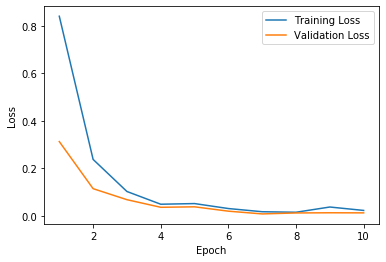

In [19]:
#Plot loss to test for overfitting.
cnn.save('food_model3.h5')
epochs = list(range(1, len(cnn.history.history['loss']) + 1))
loss = cnn.history.history['loss']
val_loss = cnn.history.history['val_loss']

plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend()
plt.title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.pdf')
plt.show();

In [20]:
#Evaluate accuracy on unseen data.
acc = cnn.evaluate(images, labels)
print('Model accuracy = {:.2f}%'.format(acc[1]*100))

1680/1680 [==============================] - 12s 7ms/sample - loss: 12.3656 - acc: 0.9744
Model accuracy = 97.44%


In [21]:
def result_freq(pred):
    '''
    Finds most probable result for each image and calculates frequacy of each result.
    
    param pred: ndarray classifier outputs
    return results: len(num_pred) list most probable class for each image (in order)
    return count: len(num_classes) list number of images classified to each class.
    '''
    results = list(np.argmax(pred, axis = 1))
    count = [results.count(i) for i in range (pred.shape[1])]
    
    return results, count

In [22]:
#Get test image predictions.
predictions = cnn.predict(images)
results, count = result_freq(predictions)

In [23]:
#Function taken from scikit-learn documentation.

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalise=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalise:
            title = 'Normalised confusion matrix'
        else:
            title = 'Confusion matrix, without normalisation'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

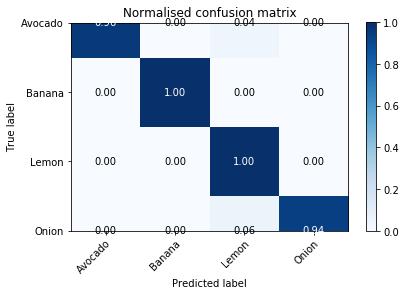

In [24]:
#Plot confusion matrix to test for misclassification bias.
plot_confusion_matrix(np.argmax(labels, axis = 1), results, categories, normalise = True);
plt.savefig('cm.pdf')

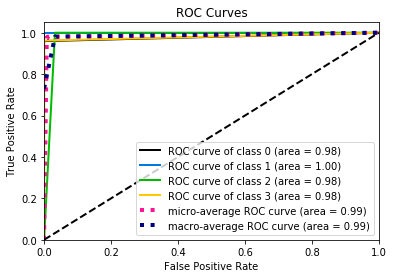

In [25]:
plot_roc(np.argmax(labels, axis = 1), predictions)
plt.savefig('roc.pdf')
plt.show()